In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-politicians-twitter-dataset/dataset.csv


In [3]:
!pip list

Package                               Version          Editable project location
------------------------------------- ---------------- -------------------------
absl-py                               0.15.0
accelerate                            0.12.0
access                                1.1.8
affine                                2.3.1
aiobotocore                           2.3.4
aiohttp                               3.8.1
aioitertools                          0.10.0
aiosignal                             1.2.0
albumentations                        1.2.1
alembic                               1.8.1
allennlp                              2.10.0
altair                                4.2.0
annoy                                 1.17.1
ansiwrap                              0.8.4
anyio                                 3.6.1
apache-beam                           2.40.0
aplus                                 0.11.0
appdirs                               1.4.4
argon2-cffi                           2

In [5]:
!pwd

/kaggle/working


In [6]:
!ls -altr

total 16
---------- 1 root root  263 Nov  3 23:58 __notebook_source__.ipynb
drwxr-xr-x 5 root root 4096 Nov  3 23:58 ..
drwxr-xr-x 2 root root 4096 Nov  3 23:58 .virtual_documents
drwxr-xr-x 3 root root 4096 Nov  3 23:58 .


# Introduction

In this notebook, we are going to treat US poiticians' twitter accounts as the nodes and mentions of them by each other as edges. Let's see what we can learn about the US politicians' twitter.

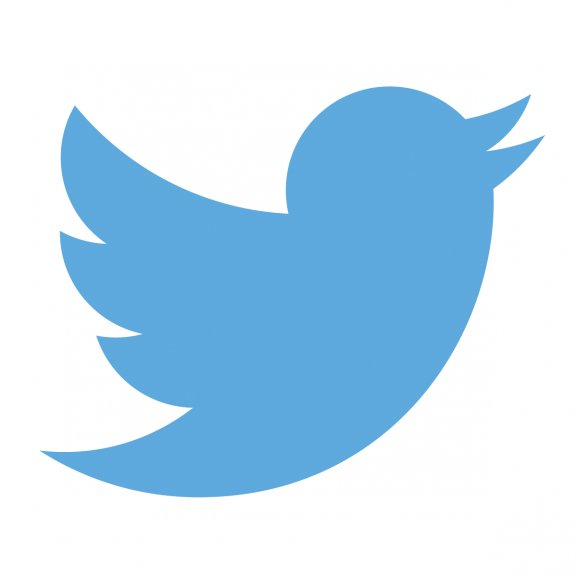

# Dependencies

In [7]:
import pandas as pd #dataframes
import numpy as no #mathematical operations
import networkx as nx #network analysis
import seaborn as sns #visualisation
import matplotlib.pyplot as plt
import gc #collecting garbage
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator #visualisation
sns.set_theme(context='notebook', style='whitegrid', palette='vlag', font='serif')

# EDA

In [9]:
!ls -altr --block-size=k /kaggle/input/us-politicians-twitter-dataset/

total 336K
drwxr-xr-x 2 nobody nogroup   0K Oct 31 09:26 .
-rw-r--r-- 1 nobody nogroup 332K Oct 31 09:26 dataset.csv
drwxr-xr-x 3 root   root      4K Nov  3 23:58 ..


In [10]:
!head -n 10 /kaggle/input/us-politicians-twitter-dataset/dataset.csv

Name,Twitter_username,Account_start_time,Account_ID,Sex,Birthplace,Birthday,Age,Instagram_username,Political_party
A. Donald McEachin,RepMcEachin,2017-01-03T00:00:00Z,816181091673448448,male,Germany,1961-10-10T00:00:00Z,59.0,repmceachin,Democratic Party
Aaron Michlewitz,RepMichlewitz,2010-06-27T00:00:00Z,160246973,male,United States of America,1978-01-01T00:00:00Z,42.0,,Democratic Party
Aaron Peskin,AaronPeskin,2010-11-13T00:00:00Z,215369273,male,United States of America,1964-06-17T00:00:00Z,56.0,apeskin52,Democratic Party
Aaron Peña,AaronPena,2007-10-31T00:00:00Z,9843332,male,United States of America,1959-06-08T00:00:00Z,61.0,,Republican Party
Aaron Schock,aaronschock,2009-03-12T00:00:00Z,23951197,male,United States of America,1981-05-28T00:00:00Z,39.0,aaronschock,Republican Party
Abby Finkenauer,Abby4Iowa,2013-03-12T00:00:00Z,1262017122,female,United States of America,1988-12-27T00:00:00Z,31.0,abby4iowa,Democratic Party
Abigail Spanberger,SpanbergerVA07,2018-12-28T00:00:00Z,107877140

In [12]:
df = pd.read_csv('/kaggle/input/us-politicians-twitter-dataset/dataset.csv',parse_dates=['Account_start_time','Birthday'])
df

,Name,Twitter_username,Account_start_time,Account_ID,Sex,Birthplace,Birthday,Age,Instagram_username,Political_party
0,A. Donald McEachin,RepMcEachin,2017-01-03 00:00:00+00:00,816181091673448448,male,Germany,1961-10-10 00:00:00+00:00,59.0,repmceachin,Democratic Party
1,Aaron Michlewitz,RepMichlewitz,2010-06-27 00:00:00+00:00,160246973,male,United States of America,1978-01-01 00:00:00+00:00,42.0,NaN,Democratic Party
2,Aaron Peskin,AaronPeskin,2010-11-13 00:00:00+00:00,215369273,male,United States of America,1964-06-17 00:00:00+00:00,56.0,apeskin52,Democratic Party
3,Aaron Peña,AaronPena,2007-10-31 00:00:00+00:00,9843332,male,United States of America,1959-06-08 00:00:00+00:00,61.0,NaN,Republican Party
4,Aaron Schock,aaronschock,2009-03-12 00:00:00+00:00,23951197,male,United States of America,1981-05-28 00:00:00+00:00,39.0,aaronschock,Republican Party
...,...,...,...,...,...,...,...,...,...,...
2509,Yvette Clarke,RepYvetteClarke,2011-01-20 00:00:00+00:00,240812994,female,United States of America,1964-11-21 00:00:00+00:00,55.0,repyvettedclarke,Democratic Party
2510,Yvette Herrell,yvette4congress,2017-08-19 00:00:00+00:00,898787903609765890,female,United States of America,1964-03-16 00:00:00+00:00,56.0,NaN,Republican Party
2511,Zephyr Teachout,zephyrteachout,2008-07-17 00:00:00+00:00,15467700,female,United States of America,1971-10-24 00:00:00+00:00,49.0,zephyrteachout,Democratic Party
2512,Zoe Lofgren,RepZoeLofgren,2011-03-17 00:00:00+00:00,267938462,female,United States of America,1947-12-21 00:00:00+00:00,72.0,repzoelofgren,Democratic Party


In [13]:
df.isna().sum()

Name                     0
Twitter_username         0
Account_start_time     391
Account_ID             331
Sex                      0
Birthplace               1
Birthday                23
Age                     23
Instagram_username    1347
Political_party          0
dtype: int64

**What is the gender ratio in the dataset?**

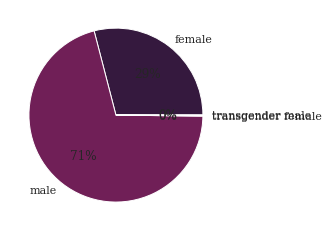

In [14]:
colors = sns.color_palette('rocket')[0:4]
data = df.groupby('Sex').size().reset_index()
plt.pie(data[0], labels=data['Sex'], colors = colors, autopct='%.0f%%')
plt.show()

**How old are the US politicians presented in the dataset? Is there any relation between gender/sex and the age?**

In [15]:
df.Sex.unique()

array(['male', 'female', 'transgender female', 'transgender male'],
      dtype=object)

In [16]:
df.Sex.value_counts()

male                  1779
female                 730
transgender female       4
transgender male         1
Name: Sex, dtype: int64

In [17]:
data.head()

,Sex,0
0,female,730
1,male,1779
2,transgender female,4
3,transgender male,1


Mean age sex male: 59.34258210645527 
Mean age sex female: 57.32361111111111 
Mean age sex transgender male: 38.0 
Mean age sex transgender female: 51.25


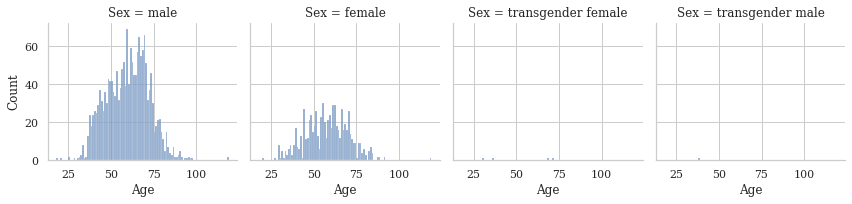

In [18]:
fig = sns.displot(
    df, x="Age", col="Sex",
    binwidth=1, height=3,
)
print('Mean age sex male:',df[df.Sex=='male'].Age.mean(),'\nMean age sex female:',df[df.Sex=='female'].Age.mean(),'\nMean age sex transgender male:',df[df.Sex=='transgender male'].Age.mean(),'\nMean age sex transgender female:',df[df.Sex=='transgender female'].Age.mean())

**Which political parties members are presented in the dataset?**

In [19]:
print('Number of parties', len(df.Political_party.unique()),'\n')
print(df.Political_party.value_counts())

Number of parties 80 

Democratic Party                           1232
Republican Party                           1068
California Democratic Party                  25
Minnesota Democratic–Farmer–Labor Party      23
independent politician                       22
                                           ... 
Colombian Liberal Party                       1
Panhellenic Socialist Movement                1
Oregon Republican Party                       1
Liberal Party of New York                     1
Likud                                         1
Name: Political_party, Length: 80, dtype: int64


    Political_party     0
0  Democratic Party  1232
1             Other   214
2  Republican Party  1068


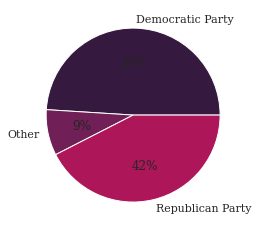

5301

In [20]:
data = df.copy()
data.loc[(data['Political_party']!= 'Democratic Party') & (data['Political_party']!='Republican Party'), 'Political_party'] = 'Other'
data = data.groupby('Political_party').size().reset_index()
print(data)
colors = sns.color_palette('rocket')[0:4]
plt.pie(data[0], labels=data['Political_party'], autopct='%.0f%%', colors=colors)
plt.show()
gc.collect()

**What are top birth places of the politicians present in the dataset?**

In [21]:
df.Birthplace.value_counts()

United States of America      2366
Germany                         17
Somalia                          9
Guatemala                        8
Colombia                         8
Mexico                           8
India                            8
Empire of Japan                  7
Taiwan                           7
Japan                            6
Cuba                             6
Canada                           6
United Kingdom                   5
Peru                             5
Spain                            5
South Korea                      4
Pakistan                         4
Switzerland                      3
Dominican Republic               3
Philippines                      3
Italy                            2
Vietnam                          2
Thailand                         2
Netherlands                      2
Venezuela                        1
France                           1
Czech Republic                   1
Cambodia                         1
Puerto Rico         

For convenience, let's replace all the other countries with 'Other'

                 Birthplace     0
0                     Other   148
1  United States of America  2366


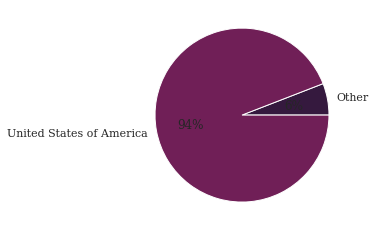

2318

In [22]:
data = df.copy()
data.loc[(data['Birthplace']!= 'United States of America') & (data['Birthplace']!='United States of America'), 'Birthplace'] = 'Other'
data = data.groupby('Birthplace').size().reset_index()
print(data)
plt.pie(data[0], labels=data['Birthplace'], autopct='%.0f%%',colors=colors)
plt.show()
gc.collect()

**What are top surnames among the politicians listed in the dataset?**

In [23]:
df['Surname'] = df['Name'].apply(lambda x:x.split(' ')[-1])
df['Surname']

0         McEachin
1       Michlewitz
2           Peskin
3             Peña
4           Schock
           ...    
2509        Clarke
2510       Herrell
2511      Teachout
2512       Lofgren
2513        Istvan
Name: Surname, Length: 2514, dtype: object

In [24]:
print('Total number of surnames', len(df.Surname.unique()))
print(f'Ratio surnames presented in the dataset:people presented in the dataset: {len(df.Surname.unique())}:{df.shape[0]}')

Total number of surnames 1472
Ratio surnames presented in the dataset:people presented in the dataset: 1472:2514


Top surnames
      Surname  frequency
0       Smith         28
1         Jr.         24
2     Johnson         17
3      Murphy         13
4       Pence         13
...       ...        ...
1467    Comer          1
1468   Allsup          1
1469  Beutler          1
1470     Frey          1
1471   Istvan          1

[1472 rows x 2 columns]
Distribution of surname frequencies


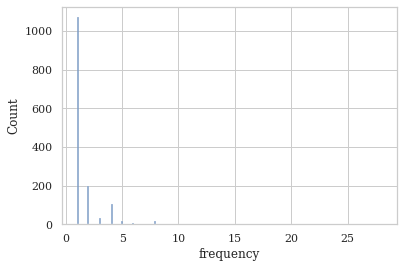

In [25]:
print('Top surnames')
data = df.Surname.value_counts().reset_index().rename(columns={'index':'Surname', 'Surname': 'frequency'})
print(data)
print('Distribution of surname frequencies')
sns.histplot(data.frequency)
plt.show()

In [26]:
data.head(20)

,Surname,frequency
0,Smith,28
1,Jr.,24
2,Johnson,17
3,Murphy,13
4,Pence,13
5,Carson,13
6,Lee,12
7,Jones,12
8,Brown,11
9,Kennedy,11


Top-20 surnames


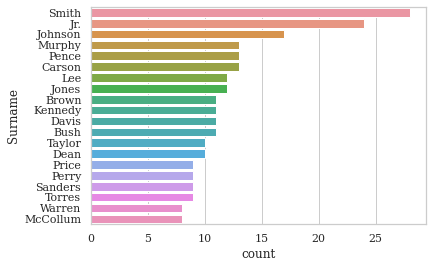

In [27]:
sns.countplot(y="Surname", data=df,order=df.Surname.value_counts().iloc[:20].index)
print("Top-20 surnames")

**When were most of the accounts in the dataset created?**

<AxesSubplot:xlabel='Account_start_time', ylabel='Count'>

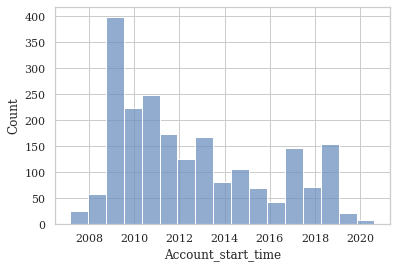

In [28]:
sns.histplot(df.Account_start_time)

***Is there any relation between gender/sex and being a member of certain political party?*****

Political_party  Sex               
Democratic       female                483
                 male                  745
                 transgender female      3
                 transgender male        1
Other            female                 82
                 male                  131
                 transgender female      1
Republican       female                165
                 male                  903
dtype: int64


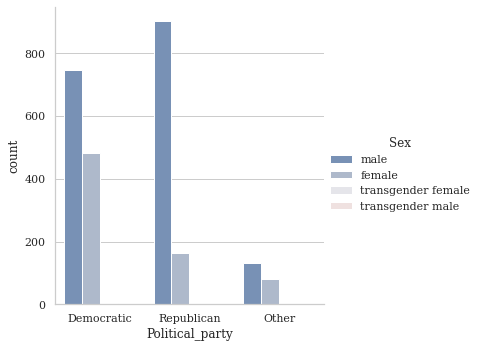

In [29]:
df.loc[(df['Political_party']!= 'Democratic Party') & (df['Political_party']!='Republican Party'), 'Political_party'] = 'Other'
df.loc[(df['Political_party'] == 'Democratic Party'), 'Political_party'] = 'Democratic'
df.loc[(df['Political_party'] == 'Republican Party'), 'Political_party'] = 'Republican'

sns.catplot(x="Political_party", hue="Sex", data=df, kind="count")

print(df.groupby(['Political_party','Sex']).size())

**What is the most common month of birth among these politicians?**

<AxesSubplot:xlabel='Birthday', ylabel='Count'>

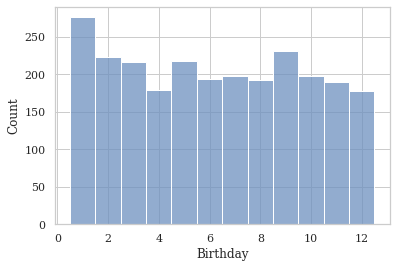

In [30]:
sns.histplot(df.Birthday.apply(lambda x: x.month),discrete=True)

The distribution is approximately uniform!

# Feature engineering

Now we can go to the next step and collect the features we need for the network analysis.

In [31]:
! pip install tweepy #let's install the Twitter API scrapper
import tweepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 3.6 MB/s eta 0:00:00


In [32]:
#US politicians tweets dataframe: text - text content of the tweet, author - the creator of the tweet, political party - political party of the tweet sender,
#reply_to - to whose tweet this tweet replies (if any).
us_tweets = pd.DataFrame(columns=['text', 'author', 'political_party', 'reply_to', 'user_mentions','retweet_count', 'favorite_count', 'created_at'])

**Randomly sample the original DataFrame**
* match Twitter API v1 max search count/15min (900) OAuth
* match Twitter API v1 max search count/15min (1500) Bearer Auth

In [ ]:
# Randomly sample 900 of the original 2514 rows

df = df.sample(900)

**Let's start the API**

In [34]:
from kaggle_secrets import UserSecretsClient

# Tweepy Authentication 
# https://docs.tweepy.org/en/v4.12.0/authentication.html

"""
# OAuth 1.0a User Context (900 Tweets/15min)
secret_label = 'your-secret-label'
api_key = UserSecretsClient().get_secret('api_key')
secret_api_key = UserSecretsClient().get_secret('api_key_secret')
access_token = UserSecretsClient().get_secret('access_token')
access_token_secret = UserSecretsClient().get_secret('access_token_secret')

auth = tweepy.OAuthHandler(api_key, secret_api_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)
"""

# OAuth 2.0 Bearer Token (1500 Tweets/15min)
bearer_token = UserSecretsClient().get_secret('bearer_token')

auth = tweepy.OAuth2BearerHandler(bearer_token)
api = tweepy.API(auth)


count = 0
error = 0

**Let's collect tweets!**

In [35]:
# CAUTION: Long-running process, normal OAuth can only retrieve 900/15min rate

def get_user_tweets(username, political_party):
   global api, us_tweets,count,error
   count+=1
   try:
        tweets = api.user_timeline(screen_name=username, 
                           include_rts = False,
                           tweet_mode = 'extended',
                           )
        table = [[tweet._json['full_text'],username, political_party, tweet._json['in_reply_to_user_id'],tweet._json['entities']['user_mentions'],tweet._json['retweet_count'], tweet._json['favorite_count'],tweet._json['created_at']] for  tweet in tweets]
        df = pd.DataFrame(table)
        df.columns = ['text', 'author', 'political_party','reply_to', 'user_mentions','retweet_count', 'favorite_count', 'created_at']
        us_tweets = us_tweets.append(df)
   except:
        error+=1
        print(error, count)
        if count%100==True:
            print(count)
df.apply(lambda x:get_user_tweets(x.Twitter_username, x.Political_party),axis=1)
gc.collect()

1 38
2 49
3 71
4 72
5 86
6 105
7 108
8 110
9 115
10 117
11 123
12 125
13 132
14 150
15 152
16 154
17 156
18 194
19 195
20 196
21 197
22 198
23 225
24 227
25 229
26 231
27 251
28 253
29 263
30 268
31 269
32 273
33 279
34 282
35 286
36 291
37 292
38 303
39 305
40 318
41 320
42 327
43 328
44 329
45 330
46 343
47 360
48 373
49 381
50 383
51 396
52 399
53 400
54 402
55 407
56 409
57 429
58 430
59 431
60 448
61 449
62 499
63 500
64 515
65 520
66 527
67 528
68 539
69 541
70 560
71 562
72 570
73 574
74 575
75 576
76 577
77 578
78 600
79 607
80 611
81 613
82 627
83 629
84 641
85 645
86 647
87 665
88 668
89 678
90 680
91 688
92 689
93 690
94 693
95 707
96 708
97 760
98 761
99 762
100 795
101 796
102 798
103 799
104 801
801
105 808
106 809
107 820
108 822
109 829
110 835
111 847
112 849
113 852
114 853
115 864
116 866
117 868
118 871
119 873
120 876
121 916
122 918
123 947
124 957
125 968
126 997
127 999
128 1004
129 1012
130 1014
131 1031
132 1053
133 1058
134 1064
135 1065
136 1066
137 1067
138

0

In [36]:
# Save and download work

df.to_csv('uspol_tweets_2514count_oauth20bearer.csv', index=False)

**Let's make an overview of the collected messages!**

Which author do most tweets in the dataset belong to?

Top-20 authors


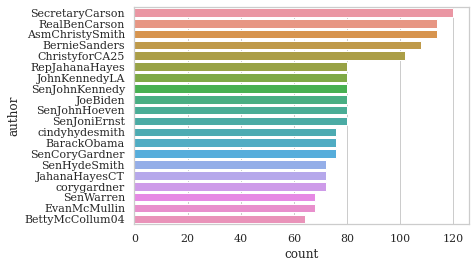

In [37]:
sns.countplot(y="author", data=us_tweets,order=us_tweets.author.value_counts().iloc[:20].index)
print("Top-20 authors")
plt.show()

**What are the most popular tweets in the dataset?**

In [38]:
top_retweeted = us_tweets.sort_values('retweet_count', ascending=False).head(10)
top_retweeted

,text,author,political_party,reply_to,user_mentions,retweet_count,favorite_count,created_at
12,Look at this Mark \n\nHow you gone kick me off...,kanyewest,Republican,None,[],102565,1111066,Sat Oct 08 05:38:02 +0000 2022
11,Lmao at a billionaire earnestly trying to sell...,AOC,Democratic,NaN,[],76808,704836,Wed Nov 02 03:25:24 +0000 2022
11,Lmao at a billionaire earnestly trying to sell...,AOC,Democratic,NaN,[],76808,704840,Wed Nov 02 03:25:24 +0000 2022
1,59 years ago today I was released from Parchma...,repjohnlewis,Democratic,None,[],74196,325015,Tue Jul 07 18:32:18 +0000 2020
10,Bigger corporate profits account for *over hal...,RepKatiePorter,Democratic,NaN,[],64260,138881,Tue Oct 18 20:56:02 +0000 2022
13,Silencing a significant number of voters and e...,SecretaryCarson,Other,NaN,[],48560,199347,Sat Jan 09 01:43:00 +0000 2021
13,Silencing a significant number of voters and e...,SecretaryCarson,Other,NaN,[],48560,199380,Sat Jan 09 01:43:00 +0000 2021
13,Silencing a significant number of voters and e...,SecretaryCarson,Democratic,NaN,[],48560,199380,Sat Jan 09 01:43:00 +0000 2021
13,Silencing a significant number of voters and e...,SecretaryCarson,Republican,NaN,[],48560,199380,Sat Jan 09 01:43:00 +0000 2021
13,Silencing a significant number of voters and e...,SecretaryCarson,Republican,NaN,[],48560,199347,Sat Jan 09 01:43:00 +0000 2021


In [39]:
top_liked = us_tweets.sort_values('favorite_count',ascending=False).head(10)
top_liked

,text,author,political_party,reply_to,user_mentions,retweet_count,favorite_count,created_at
12,Look at this Mark \n\nHow you gone kick me off...,kanyewest,Republican,None,[],102565,1111066,Sat Oct 08 05:38:02 +0000 2022
11,Lmao at a billionaire earnestly trying to sell...,AOC,Democratic,NaN,[],76808,704840,Wed Nov 02 03:25:24 +0000 2022
11,Lmao at a billionaire earnestly trying to sell...,AOC,Democratic,NaN,[],76808,704836,Wed Nov 02 03:25:24 +0000 2022
14,KANYE 2024 https://t.co/Zm2pKcn12t,kanyewest,Republican,None,[],46968,490381,Wed Nov 04 09:04:50 +0000 2020
10,Who you think created cancel culture?,kanyewest,Republican,None,[],32489,430036,Sun Oct 09 04:25:09 +0000 2022
13,2024 https://t.co/CJsmMGhExW,kanyewest,Republican,None,[],34139,407802,Sat Oct 08 03:27:58 +0000 2022
11,One week.,drbiden,Democratic,NaN,[],21716,384384,Wed Jan 13 14:18:42 +0000 2021
9,Iranian youth are leading a revolution against...,kanyewest,Republican,None,[],47870,362538,Sun Oct 09 04:56:51 +0000 2022
1,59 years ago today I was released from Parchma...,repjohnlewis,Democratic,None,[],74196,325015,Tue Jul 07 18:32:18 +0000 2020
1,"Yo @elonmusk while I have your attention, why ...",AOC,Democratic,NaN,"[{'screen_name': 'elonmusk', 'name': 'Elon Mus...",26521,284090,Thu Nov 03 14:23:11 +0000 2022


**What is the relation between the number of retweets and the number of likes?**

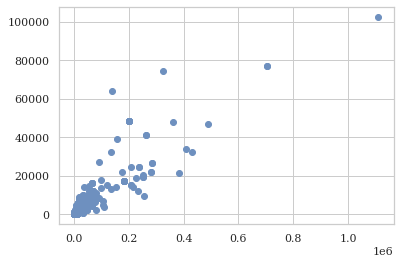

In [40]:
plt.scatter(us_tweets.favorite_count, us_tweets.retweet_count)

**Which party members have more retweets on their likes and posts on average?**

In [41]:
us_tweets['retweet_count'] = pd.to_numeric(us_tweets["retweet_count"])
us_tweets['favorite_count'] = pd.to_numeric(us_tweets["favorite_count"])

<AxesSubplot:xlabel='political_party', ylabel='retweet_count_sqrt'>

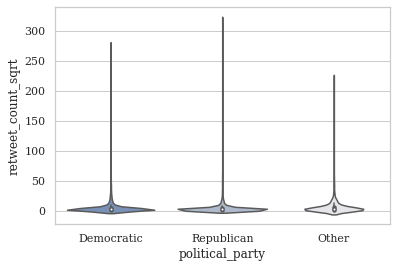

In [42]:
us_tweets['retweet_count_sqrt'] = np.sqrt(us_tweets['retweet_count'])
sns.violinplot(data=us_tweets[['retweet_count_sqrt', 'political_party']], y='retweet_count_sqrt', x = 'political_party')

<AxesSubplot:xlabel='political_party', ylabel='favorite_count_sqrt'>

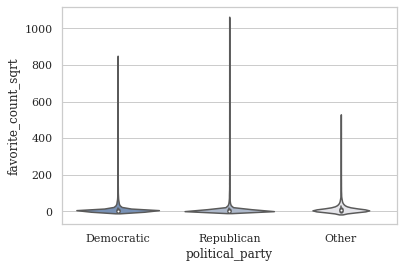

In [43]:
us_tweets['favorite_count_sqrt'] = np.sqrt(us_tweets['favorite_count'])
sns.violinplot(data=us_tweets[['favorite_count_sqrt', 'political_party']], y='favorite_count_sqrt', x = 'political_party')

**Let's draw the word clouds to see the most commonly used words.**

Top words for Republicans


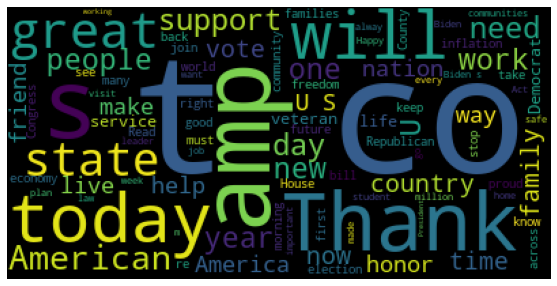

Top words for Democrats


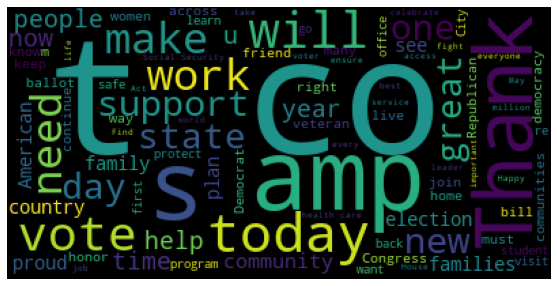

Top words for Others


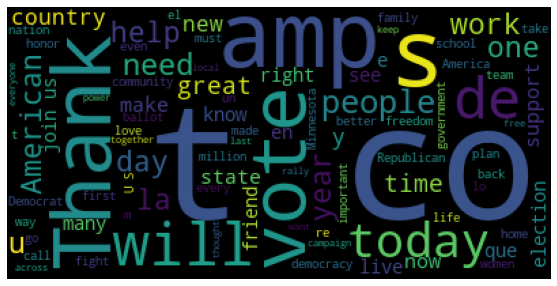

In [44]:
STOPWORDS.update(['https', 'ht', 'tps'])
plt.figure( figsize=(10,5) )
text = " ".join(review for review in us_tweets[us_tweets.political_party=='Republican'].text.dropna().astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS,max_words=90).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
print('Top words for Republicans')
plt.show()
gc.collect()

plt.figure( figsize=(10,5) )
text = " ".join(review for review in us_tweets[us_tweets.political_party=='Democratic'].text.dropna().astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS,max_words=90).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
print('Top words for Democrats')
plt.show()

plt.figure( figsize=(10,5) )
text = " ".join(review for review in us_tweets[us_tweets.political_party=='Other'].text.dropna().astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS,max_words=90).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
print('Top words for Others')
plt.show()

In [45]:
#mentions dataset: how many times one politician (by) has mentioned another (who)
mentions = pd.DataFrame(columns=['by', 'who'])

**Now let's generated a dataset from which we will be able to generate a graph. We have already created, and now it's time to fill it with data.**

In [46]:
count = 0
us_politicians = set(df.Twitter_username)
def generate_mentions(author,mentions_list):
    global mentions, count,us_politicians
    count+=1
    if count%500==0:
        print(count)
    for el in mentions_list:
        if el['screen_name'] in us_politicians:
            new_dict = {'by': author, 'who': el['screen_name']}
            mentions = mentions.append(new_dict, ignore_index=True)
    
    
us_tweets.apply(lambda x: generate_mentions(x.author, x.user_mentions),axis=1)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500


0     None
1     None
2     None
3     None
4     None
      ... 
11    None
12    None
13    None
14    None
15    None
Length: 19892, dtype: object

In [47]:
mentions

,by,who
0,RepMcEachin,POTUS
1,RepMichlewitz,SenRodrigues
2,RepMichlewitz,VP
3,RepMichlewitz,RonMariano
4,Abby4Iowa,Axne4Congress
...,...,...
1401,RepLoriTrahan,RepKatiePorter
1402,RepLoriTrahan,RepChrisStewart
1403,LorraineCortesV,GavinNewsom
1404,RepLouieGohmert,RepCloudTX


**Now let's count how many times each politician mentioned another politician**

In [48]:
mentions=mentions.groupby(['by','who']).size().reset_index().rename(columns={0:'Count'})

# Analysis.

**Let's create the network first**

In [49]:
G = nx.from_pandas_edgelist(mentions,'by','who', create_using=nx.DiGraph())
print('Accounts that have metioned someone at least ones or have been mentioned at least ones =',G.number_of_nodes())
#let's add the other users to the graph
G.add_nodes_from(us_tweets.author)
print('Total mentions between accounts:maximum possible mentions between accounts (which proportion of politicians have mentioned each other at least once)',
      G.number_of_edges(), ':', G.number_of_nodes()*(G.number_of_nodes()-1))

Accounts that have metioned someone at least ones or have been mentioned at least ones = 705
Total mentions between accounts:maximum possible mentions between accounts (which proportion of politicians have mentioned each other at least once) 836 : 1346760


**And now let's set the node attribute(political party) and edge attributes (times mentioned)**

In [50]:
usernames = df.Twitter_username
political_party = df.Political_party
attrs = {node:party for node,party in zip(usernames,political_party)}
nx.set_node_attributes(G, attrs,"Party")
nx.set_edge_attributes(G,{(author,to):times for author,to,times in zip(mentions.by,mentions.who,mentions.Count)},'Times Mentioned')
gc.collect()

5169

**What is the clustering coeficient? What is the transitivity?**

In [51]:
print('Average clustering coeficient', nx.average_clustering(G))
print('Transitivity', nx.transitivity(G))

Average clustering coeficient 0.01443600443203899
Transitivity 0.029733009708737865


**Surprisingly, the transitivity and average clustering coeficients are very low. Are these metrics different for Democrats and Republicans?**

In [52]:
D = G.subgraph([node[0] for node in G.nodes(data=True) if node[1]['Party']=='Democratic'])
R = G.subgraph([node[0] for node in G.nodes(data=True) if node[1]['Party']=='Republican'])
print('N Democrats',D.number_of_nodes(), 'N Republicans', R.number_of_nodes())
print('Average clustering coeficient democrats only', nx.average_clustering(D))
print('Transitivity democrats only', nx.transitivity(D))
print('Average clustering coeficient republicans only', nx.average_clustering(R))
print('Transitivity republicans only', nx.transitivity(R))

N Democrats 611 N Republicans 472
Average clustering coeficient democrats only 0.014692211500722136
Transitivity democrats only 0.047038327526132406
Average clustering coeficient republicans only 0.011131819662149725
Transitivity republicans only 0.027950310559006212


**Now let's draw the network**

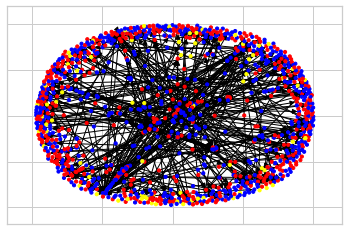

In [53]:
colors = []
for el in G.nodes(data="Party"):
    if el[1] == 'Republican':
        colors.append('red')
    elif el[1] == 'Democratic':
        colors.append('blue')
    else:
        colors.append('yellow')
    
nx.draw_networkx(G, node_size=10, node_color = colors, with_labels=False)

**What are the central nodes?**

Let's find the nodes with the largest page ranks!

page ranks with alpha=0
[('AGDougPeterson', 0.0008613264427217916), ('GovRicketts', 0.0008613264427217916), ('Abby4Iowa', 0.0008613264427217916), ('Axne4Congress', 0.0008613264427217916), ('AjaLBrown', 0.0008613264427217916), ('MichaelDTubbs', 0.0008613264427217916), ('AlyssaMastro44', 0.0008613264427217916), ('jonfavs', 0.0008613264427217916), ('AmbCMBraun', 0.0008613264427217916), ('JoeBiden', 0.0008613264427217916), ('KamalaHarris', 0.0008613264427217916), ('AmbDennisRoss', 0.0008613264427217916), ('AmyMcGrathKY', 0.0008613264427217916), ('ElaineLuriaVA', 0.0008613264427217916), ('AndrewGillum', 0.0008613264427217916), ('AngieCraigMN', 0.0008613264427217916), ('amyklobuchar', 0.0008613264427217916), ('AnnRomney', 0.0008613264427217916), ('MittRomney', 0.0008613264427217916), ('Ann_Kirkpatrick', 0.0008613264427217916)]

Nodes with page rank of 0.0005847953216374269: total nodes 0 : 1161


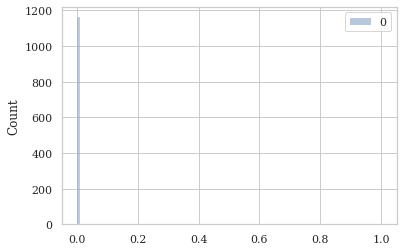

In [54]:
print('page ranks with alpha=0')
dic = nx.pagerank(G,alpha=0,max_iter=1000)
dic2=dict(sorted(dic.items(),key= lambda x:x[1]),reverse=True)
print(list(dic2.items())[0:20])
sns.histplot(dic2.values(), binwidth=0.01)
print('\nNodes with page rank of 0.0005847953216374269: total nodes',len([val for val in dic2.values() if val == 0.0005847953216374269]),':',G.number_of_nodes())

In [55]:
[x for x in list(dic2.items())[0:20]]

[('AGDougPeterson', 0.0008613264427217916),
 ('GovRicketts', 0.0008613264427217916),
 ('Abby4Iowa', 0.0008613264427217916),
 ('Axne4Congress', 0.0008613264427217916),
 ('AjaLBrown', 0.0008613264427217916),
 ('MichaelDTubbs', 0.0008613264427217916),
 ('AlyssaMastro44', 0.0008613264427217916),
 ('jonfavs', 0.0008613264427217916),
 ('AmbCMBraun', 0.0008613264427217916),
 ('JoeBiden', 0.0008613264427217916),
 ('KamalaHarris', 0.0008613264427217916),
 ('AmbDennisRoss', 0.0008613264427217916),
 ('AmyMcGrathKY', 0.0008613264427217916),
 ('ElaineLuriaVA', 0.0008613264427217916),
 ('AndrewGillum', 0.0008613264427217916),
 ('AngieCraigMN', 0.0008613264427217916),
 ('amyklobuchar', 0.0008613264427217916),
 ('AnnRomney', 0.0008613264427217916),
 ('MittRomney', 0.0008613264427217916),
 ('Ann_Kirkpatrick', 0.0008613264427217916)]

Surprisingly,all the nodes in the network have the same page rank with alpha=0. This means that the probability to reach any account while surfing the network is the same.

Which nodes have most in-directed edges (e.g. who are the most mentioned politicians)?

top mentioned accounts:
[('POTUS', 97), ('SpeakerPelosi', 46), ('realDonaldTrump', 26), ('JoeBiden', 23), ('VP', 14), ('KamalaHarris', 13), ('HillaryClinton', 11), ('BarackObama', 10), ('RonMariano', 7), ('maura_healey', 6), ('GovernorVA', 6), ('DanPatrick', 5), ('ChrisMurphyCT', 5), ('timkaine', 5), ('CoryBooker', 5), ('RepBradWenstrup', 5), ('RepKevinBrady', 5), ('amyklobuchar', 4), ('CaptMarkKelly', 4), ('TishJames', 4), ('Tony4WI', 4), ('RepKClark', 4), ('SenWarren', 4), ('KarenSpilka', 4), ('ewarren', 4), ('RepAndyBiggsAZ', 4), ('KarlRove', 4), ('seanhannity', 4), ('BillClinton', 4), ('SenMikeLee', 4), ('Sen_JoeManchin', 4), ('ChuckGrassley', 4), ('MichaelDTubbs', 3), ('SenSchumer', 3), ('KimReynoldsIA', 3), ('SenAlexander', 3), ('RepDebDingell', 3), ('RepLizCheney', 3), ('RepMichlewitz', 3), ('SenMarkey', 3), ('GovTimWalz', 3), ('BetoORourke', 3), ('MassLtGov', 3), ('ChrisVanHollen', 3), ('marcorubio', 3), ('RandPaul', 3), ('SenCapito', 3), ('glennbeck', 3), ('GovBillLee', 3), ('

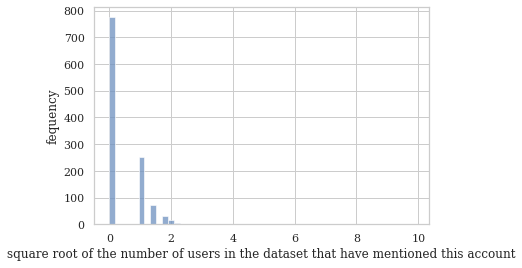

In [56]:
dic = G.in_degree()
#dic2=dict(sorted(dic,key= lambda x:x[1]), reverse=True)
print('top mentioned accounts:')
print(sorted(list(dic),reverse=True,key=lambda x:x[1])[0:50])
sns.histplot(np.sqrt([el[1] for el in list(dic)]))
plt.xlabel('square root of the number of users in the dataset that have mentioned this account')
plt.ylabel('fequency')
plt.show()

In [57]:
[x for x in sorted(list(dic),reverse=True,key=lambda x:x[1])[0:50]]

[('POTUS', 97),
 ('SpeakerPelosi', 46),
 ('realDonaldTrump', 26),
 ('JoeBiden', 23),
 ('VP', 14),
 ('KamalaHarris', 13),
 ('HillaryClinton', 11),
 ('BarackObama', 10),
 ('RonMariano', 7),
 ('maura_healey', 6),
 ('GovernorVA', 6),
 ('DanPatrick', 5),
 ('ChrisMurphyCT', 5),
 ('timkaine', 5),
 ('CoryBooker', 5),
 ('RepBradWenstrup', 5),
 ('RepKevinBrady', 5),
 ('amyklobuchar', 4),
 ('CaptMarkKelly', 4),
 ('TishJames', 4),
 ('Tony4WI', 4),
 ('RepKClark', 4),
 ('SenWarren', 4),
 ('KarenSpilka', 4),
 ('ewarren', 4),
 ('RepAndyBiggsAZ', 4),
 ('KarlRove', 4),
 ('seanhannity', 4),
 ('BillClinton', 4),
 ('SenMikeLee', 4),
 ('Sen_JoeManchin', 4),
 ('ChuckGrassley', 4),
 ('MichaelDTubbs', 3),
 ('SenSchumer', 3),
 ('KimReynoldsIA', 3),
 ('SenAlexander', 3),
 ('RepDebDingell', 3),
 ('RepLizCheney', 3),
 ('RepMichlewitz', 3),
 ('SenMarkey', 3),
 ('GovTimWalz', 3),
 ('BetoORourke', 3),
 ('MassLtGov', 3),
 ('ChrisVanHollen', 3),
 ('marcorubio', 3),
 ('RandPaul', 3),
 ('SenCapito', 3),
 ('glennbeck', 3)

Which nodes have most out-directed edges (e.g. which politicians have mentioned the others most time)?

accounts that tend to mention most of other accounts
[('CharlieBakerMA', 11), ('CongBillPosey', 8), ('DonBlankenship', 8), ('LadySunshineNM', 8), ('PerkinsForUSSen', 8), ('RepAndyBiggsAZ', 7), ('EFillerCorn', 7), ('GinaRaimondo', 7), ('RealBartStupak', 7), ('SenJohnMccain', 7), ('congressmanhice', 7), ('BarackObama', 6), ('CarolynDykema', 6), ('EleanorNorton', 6), ('RepLawrence', 6), ('JoyceCraigNH', 6), ('RepLoriTrahan', 5), ('EileenDonoghue', 5), ('EricLesser', 5), ('RepBillJohnson', 5), ('RepCummings', 5), ('RepDaveJoyce', 5), ('RepHolding', 5), ('RepJasonCrow', 5), ('SenChrisDodd', 5), ('davidaxelrod', 5), ('asolg', 5), ('billhaslam', 5), ('ericgarcetti', 5), ('ColinVanOstern', 4), ('JohnSununu', 4), ('RepJeffDuncan', 4), ('EleniForCA', 4), ('Evan_Low', 4), ('JimFKenney', 4), ('Psaki44', 4), ('RepChrisStewart', 4), ('RepJimCosta', 4), ('RepRutherfordFL', 4), ('SenDonnelly', 4), ('USRepKeating', 4), ('andyschor', 4), ('dawnzimmernj', 4), ('sebelius', 4), ('KamalaHarris', 3), ('Arave

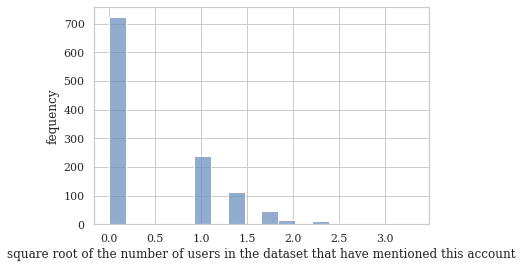

In [58]:
dic = G.out_degree()
#dic2=dict(sorted(dic,key= lambda x:x[1]), reverse=True)
print('accounts that tend to mention most of other accounts')
print(sorted(list(dic),reverse=True,key=lambda x:x[1])[0:50])
sns.histplot(np.sqrt([el[1] for el in list(dic)]))
plt.xlabel('square root of the number of users in the dataset that have mentioned this account')
plt.ylabel('fequency')
plt.show()

In [59]:
[x for x in sorted(list(dic),reverse=True,key=lambda x:x[1])[0:50]]

[('CharlieBakerMA', 11),
 ('CongBillPosey', 8),
 ('DonBlankenship', 8),
 ('LadySunshineNM', 8),
 ('PerkinsForUSSen', 8),
 ('RepAndyBiggsAZ', 7),
 ('EFillerCorn', 7),
 ('GinaRaimondo', 7),
 ('RealBartStupak', 7),
 ('SenJohnMccain', 7),
 ('congressmanhice', 7),
 ('BarackObama', 6),
 ('CarolynDykema', 6),
 ('EleanorNorton', 6),
 ('RepLawrence', 6),
 ('JoyceCraigNH', 6),
 ('RepLoriTrahan', 5),
 ('EileenDonoghue', 5),
 ('EricLesser', 5),
 ('RepBillJohnson', 5),
 ('RepCummings', 5),
 ('RepDaveJoyce', 5),
 ('RepHolding', 5),
 ('RepJasonCrow', 5),
 ('SenChrisDodd', 5),
 ('davidaxelrod', 5),
 ('asolg', 5),
 ('billhaslam', 5),
 ('ericgarcetti', 5),
 ('ColinVanOstern', 4),
 ('JohnSununu', 4),
 ('RepJeffDuncan', 4),
 ('EleniForCA', 4),
 ('Evan_Low', 4),
 ('JimFKenney', 4),
 ('Psaki44', 4),
 ('RepChrisStewart', 4),
 ('RepJimCosta', 4),
 ('RepRutherfordFL', 4),
 ('SenDonnelly', 4),
 ('USRepKeating', 4),
 ('andyschor', 4),
 ('dawnzimmernj', 4),
 ('sebelius', 4),
 ('KamalaHarris', 3),
 ('AravellaSimot

Which nodes have the highest closeness centrality (e.g. from which nodes it is easiest to get to the other nodes using only edges (mentions) presented in the dataset)?

Accounts:
[('POTUS', 0.08859592809977991), ('SpeakerPelosi', 0.040654562099481234), ('JoeBiden', 0.022862541332073688), ('realDonaldTrump', 0.022528735632183907), ('BarackObama', 0.021354679802955665), ('CaptMarkKelly', 0.017078427249789738), ('VP', 0.016762452107279696), ('Tony4WI', 0.016298491379310345), ('RashidaTlaib', 0.015326276735050198), ('SteveSisolak', 0.014942528735632184), ('StevenHorsford', 0.014942528735632184), ('SusieLeeNV', 0.01484735339336701), ('KamalaHarris', 0.011969496021220159), ('HillaryClinton', 0.011172413793103448), ('maura_healey', 0.010564570655848546), ('RonMariano', 0.006631299734748011), ('GovernorVA', 0.005280172413793104), ('SenMikeLee', 0.005070993914807302), ('RepBradWenstrup', 0.004967159277504105), ('ChrisMurphyCT', 0.004693486590038314), ('SenRodrigues', 0.004655172413793103), ('SenWhitehouse', 0.004655172413793103), ('timkaine', 0.004433497536945812), ('CoryBooker', 0.004433497536945812), ('RepKevinBrady', 0.004433497536945812), ('DanPatrick', 0.

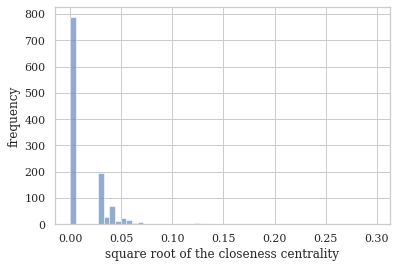

In [60]:
dic = nx.closeness_centrality(G)
print('Accounts:')
#print(dic)
print(sorted(list(dic.items()),reverse=True,key=lambda x:x[1])[0:50])
sns.histplot(np.sqrt([el[1] for el in list(dic.items())]))
plt.xlabel('square root of the closeness centrality')
plt.ylabel('frequency')
plt.show()

In [61]:
[x for x in sorted(list(dic.items()),reverse=True,key=lambda x:x[1])[0:50]]

[('POTUS', 0.08859592809977991),
 ('SpeakerPelosi', 0.040654562099481234),
 ('JoeBiden', 0.022862541332073688),
 ('realDonaldTrump', 0.022528735632183907),
 ('BarackObama', 0.021354679802955665),
 ('CaptMarkKelly', 0.017078427249789738),
 ('VP', 0.016762452107279696),
 ('Tony4WI', 0.016298491379310345),
 ('RashidaTlaib', 0.015326276735050198),
 ('SteveSisolak', 0.014942528735632184),
 ('StevenHorsford', 0.014942528735632184),
 ('SusieLeeNV', 0.01484735339336701),
 ('KamalaHarris', 0.011969496021220159),
 ('HillaryClinton', 0.011172413793103448),
 ('maura_healey', 0.010564570655848546),
 ('RonMariano', 0.006631299734748011),
 ('GovernorVA', 0.005280172413793104),
 ('SenMikeLee', 0.005070993914807302),
 ('RepBradWenstrup', 0.004967159277504105),
 ('ChrisMurphyCT', 0.004693486590038314),
 ('SenRodrigues', 0.004655172413793103),
 ('SenWhitehouse', 0.004655172413793103),
 ('timkaine', 0.004433497536945812),
 ('CoryBooker', 0.004433497536945812),
 ('RepKevinBrady', 0.004433497536945812),
 ('

Which nodes have the highest betweenness centrality? (e.g. which nodes are included in most shortest paths)?

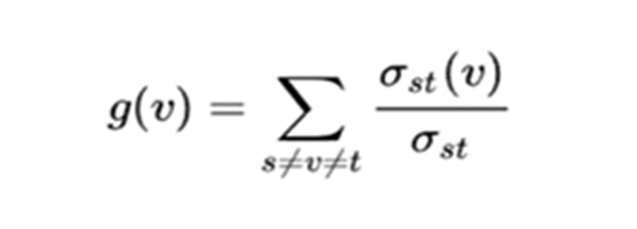

Accounts:
[('BarackObama', 0.00022611644997173544), ('JoeBiden', 0.000133636805410927), ('KamalaHarris', 9.049616692947745e-05), ('RepKevinBrady', 4.0165422034453004e-05), ('TishJames', 3.272738091696171e-05), ('RepAndyBiggsAZ', 2.5289339799470413e-05), ('ChrisMurphyCT', 1.7851298681979115e-05), ('EricLesser', 1.0413257564487816e-05), ('SenatorShaheen', 1.0413257564487816e-05), ('davidaxelrod', 1.0041355508613251e-05), ('RepJahanaHayes', 9.669453452738688e-06), ('RepCummings', 9.669453452738688e-06), ('ewarren', 7.933910525324051e-06), ('amyklobuchar', 7.4380411174912975e-06), ('RepDrewFerguson', 7.4380411174912975e-06), ('KarenSpilka', 6.694237005742168e-06), ('DWStweets', 6.694237005742168e-06), ('GovBillWeld', 6.694237005742168e-06), ('RepJimBanks', 6.694237005742168e-06), ('SenWarren', 6.446302301825791e-06), ('RepLoriTrahan', 5.950432893993038e-06), ('RepLarryBucshon', 5.950432893993038e-06), ('RepMichlewitz', 5.454563486160285e-06), ('RepGrothman', 5.206628782243908e-06), ('RepGr

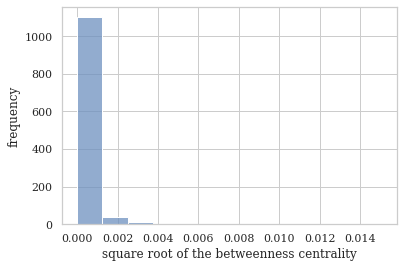

In [62]:
dic = nx.betweenness_centrality(G)
print('Accounts:')
#print(dic)
print(sorted(list(dic.items()),reverse=True,key=lambda x:x[1])[0:50])
sns.histplot(np.sqrt([el[1] for el in list(dic.items())]))
plt.xlabel('square root of the betweenness centrality')
plt.ylabel('frequency')
plt.show()

In [63]:
[x for x in sorted(list(dic.items()),reverse=True,key=lambda x:x[1])[0:50]]

[('BarackObama', 0.00022611644997173544),
 ('JoeBiden', 0.000133636805410927),
 ('KamalaHarris', 9.049616692947745e-05),
 ('RepKevinBrady', 4.0165422034453004e-05),
 ('TishJames', 3.272738091696171e-05),
 ('RepAndyBiggsAZ', 2.5289339799470413e-05),
 ('ChrisMurphyCT', 1.7851298681979115e-05),
 ('EricLesser', 1.0413257564487816e-05),
 ('SenatorShaheen', 1.0413257564487816e-05),
 ('davidaxelrod', 1.0041355508613251e-05),
 ('RepJahanaHayes', 9.669453452738688e-06),
 ('RepCummings', 9.669453452738688e-06),
 ('ewarren', 7.933910525324051e-06),
 ('amyklobuchar', 7.4380411174912975e-06),
 ('RepDrewFerguson', 7.4380411174912975e-06),
 ('KarenSpilka', 6.694237005742168e-06),
 ('DWStweets', 6.694237005742168e-06),
 ('GovBillWeld', 6.694237005742168e-06),
 ('RepJimBanks', 6.694237005742168e-06),
 ('SenWarren', 6.446302301825791e-06),
 ('RepLoriTrahan', 5.950432893993038e-06),
 ('RepLarryBucshon', 5.950432893993038e-06),
 ('RepMichlewitz', 5.454563486160285e-06),
 ('RepGrothman', 5.206628782243908e

**What is the diameter ( the length of the longest shortest path) of the network?**

In [64]:
try:
    print('The diameter is', nx.diameter(G))
except:
    print('The graph is not strong, so the diameter can not be calculated.')

The graph is not strong, so the diameter can not be calculated.


**What are the strongly connected components (groups in which you can get from any node to any another node) in the graph? How many of them are there?**

In [65]:
print('number of strongly connected components is', nx.number_strongly_connected_components(G))
print('largest strongly connected component',max(nx.strongly_connected_components(G), key=len))

number of strongly connected components is 1150
largest strongly connected component {'RepJimBanks', 'RepGregSteube', 'RepLarryBucshon'}


**What is the distribution of the sizes of the strongly connected components?**

<AxesSubplot:ylabel='Count'>

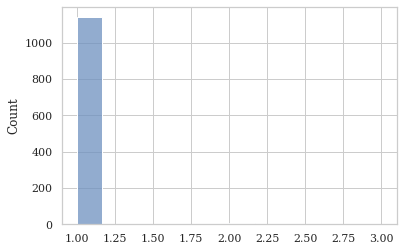

In [66]:
sns.histplot([len(x) for x in nx.strongly_connected_components(G)])

**How many weakly connected components (components in which you can get from any node to any another node if you ignore the directions of the edges) are there?**

In [67]:
print('number of weakly connected components is', nx.number_weakly_connected_components(G))
print('\n\n')
print('largest weakly connected component',max(nx.weakly_connected_components(G), key=len))
print('\n\n')
print('The largest weakly connected component size',max([len(el) for el in nx.weakly_connected_components(G)]))

number of weakly connected components is 522



largest weakly connected component {'JoeNeguse', 'corygardner', 'SenBruceTarr', 'kaybaileyhutch', 'RepBradWenstrup', 'EleanorNorton', 'RepThomasMassie', 'RepJeffDuncan', 'RepAnnieKuster', 'repblumenauer', 'arneduncan', 'RepMGriffith', 'MassLtGov', 'gregstantonaz', 'Bethvanduyne', 'BrandonPresley', 'DaveForIowa', 'senatorreid', 'RealBenCarson', 'RepAlGreen', 'timkaine', 'BarackObama', 'EddieRispone', 'GovCTW', 'RepRutherfordFL', 'SenFeinstein', 'GraceNapolitano', 'RepLoriTrahan', 'RepShimkus', 'repdavidkustoff', 'RepMcGovern', 'Denis44', 'repdonbacon', 'willjawando', 'CharlieBakerMA', 'RepCicilline', 'davidfholt', 'ChuckGrassley', 'TinaSmithMN', 'ChairmanBuckley', 'RepDebDingell', 'SecretaryCarson', 'RepJahanaHayes', 'GovJVentura', 'RepStephMurphy', 'ChristineOD', 'SenatorCantwell', 'glennbeck', 'delegatebagby', 'JohnCornyn', 'RepDavid', 'hinsonashley', 'MarkWarner', 'DonnaCampbellTX', 'RepZoeLofgren', 'RepMarcyKaptur', 'Sen_Chandler', 'to

**What is the distributions of the sizes of the weakly connected components**

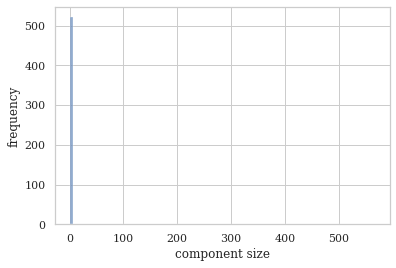

In [68]:
sns.histplot([len(x) for x in nx.weakly_connected_components(G)],binwidth=5)
plt.xlabel('component size')
plt.ylabel('frequency')
plt.show()

**We can see that there are many strongly and weakly connected components. Is the picture the same inside the political parties?**

number of weakly connected components in the Democrat network is 317



largest weakly connected component in the Democrat network {'JoeNeguse', 'janschakowsky', 'GinaRaimondo', 'RepKatieHill', 'EleanorNorton', 'BradSherman', 'SenRodrigues', 'RepAnnieKuster', 'andyschor', 'senatorbarb', 'GovWhitmer', 'SenatorBennet', 'JoeCrowleyNY', 'mayoredkoch', 'gregstantonaz', 'AlyssaMastro44', 'senatorreid', 'RepEspaillat', 'RepDarrenSoto', 'EFillerCorn', 'RepAlGreen', 'kathyhochul', 'RipSullivan48', 'SenStabenow', 'SusieLeeNV', 'keldahelenroys', 'timkaine', 'RepValDemings', 'JoseforTexas', 'BarackObama', 'MayorByronBrown', 'RepCindyAxne', 'RepJohnYarmuth', 'RepLawrence', 'RepHankJohnson', 'RepDebHaaland', 'RosenforNevada', 'RepBeatty', 'JohnKerry', 'AmyMcGrathKY', 'BillClinton', 'RepLoriTrahan', 'SenFeinstein', 'RepTonyCabral', 'CarolynDykema', 'RepMcGovern', 'RepEliotEngel', 'janekim', 'USRepKCastor', 'RepDelBene', 'RepCicilline', 'RonWyden', 'RepCummings', 'skpeake', 'ChairmanBuckley', 'RepDebD

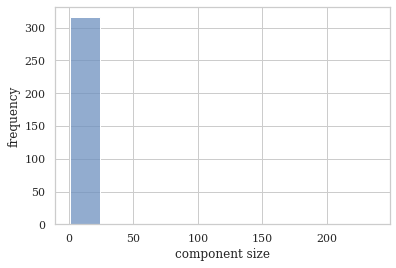

In [69]:
print('number of weakly connected components in the Democrat network is', nx.number_weakly_connected_components(D))
print('\n\n')
print('largest weakly connected component in the Democrat network',max(nx.weakly_connected_components(D), key=len))
sns.histplot([len(x) for x in nx.weakly_connected_components(D)])
plt.xlabel('component size')
plt.ylabel('frequency')
plt.show()

number of strongly connected components in the Democrat network is 606
largest strongly connected component in the Democrat network {'deanbphillips', 'amyklobuchar'}


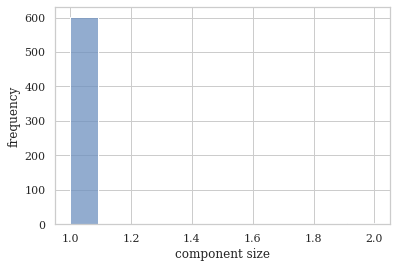

In [70]:
print('number of strongly connected components in the Democrat network is', nx.number_strongly_connected_components(D))
print('largest strongly connected component in the Democrat network',max(nx.strongly_connected_components(D), key=len))
sns.histplot([len(x) for x in nx.strongly_connected_components(D)])
plt.xlabel('component size')
plt.ylabel('frequency')
plt.show()

number of strongly connected components in the Republican network is 469
largest strongly connected component in the Republican network {'RepJimBanks', 'RepLarryBucshon', 'RepGregSteube'}


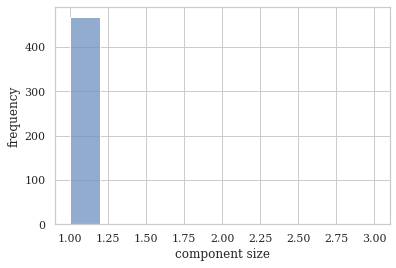

In [71]:
print('number of strongly connected components in the Republican network is', nx.number_strongly_connected_components(R))
print('largest strongly connected component in the Republican network',max(nx.strongly_connected_components(R), key=len))
sns.histplot([len(x) for x in nx.strongly_connected_components(R)])
plt.xlabel('component size')
plt.ylabel('frequency')
plt.show()

number of weakly connected components in the Republican network is 293



largest weakly connected component in the Republican network {'RepJohnCurtis', 'walshfreedom', 'joniernst', 'RepBradWenstrup', 'GovHerbert', 'RepThomasMassie', 'RepJeffDuncan', 'RepJohnJoyce', 'RepBrianBabin', 'KarlRove', 'RealBenCarson', 'JebBush', 'RepDanDonovan', 'AustinScottGA08', 'EddieRispone', 'RepJohnRose', 'RepRutherfordFL', 'TXRandy14', 'RepShimkus', 'RepHuizenga', 'repdavidkustoff', 'seanspicer', 'RandPaul', 'repdonbacon', 'PatrickMcHenry', 'ChuckGrassley', 'BobLatta', 'SpeakerRyan', 'RepGrothman', 'RepDLesko', 'SecretaryCarson', 'ChristineOD', 'SecBrouillette', 'glennbeck', 'SarahPalinUSA', 'PeteSessions', 'JohnCornyn', 'Glenn_Hegar', 'RepDavid', 'repkevinhern', 'DanLauwers', 'KimReynoldsIA', 'RepHagedorn', 'RepLouieGohmert', 'RepStefanik', 'RepMikeJohnson', 'RepCurtClawson', 'RepJohnDuncanJr', 'RepGoodlatte', 'JohnKasich', 'votecandice16', 'LindseyGrahamSC', 'treasurerloftis', 'RepMikeTurner', 'SenMi

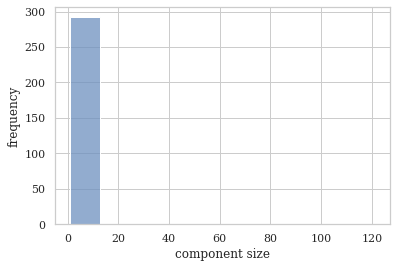

In [72]:
print('number of weakly connected components in the Republican network is', nx.number_weakly_connected_components(R))
print('\n\n')
print('largest weakly connected component in the Republican network',max(nx.weakly_connected_components(R), key=len))
sns.histplot([len(x) for x in nx.weakly_connected_components(R)])
plt.xlabel('component size')
plt.ylabel('frequency')
plt.show()

**What is the gini inequality index in the distribution of the mentions of the politicians?**

Gini inequality index: 0.5903308544432079


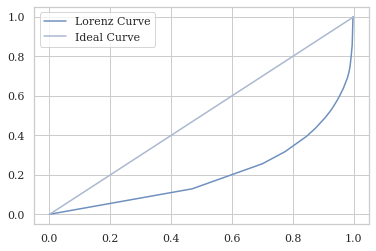

In [73]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))
#print(mentions.groupby('to')['count'].sum())
print('Gini inequality index:',gini(mentions.groupby('who')['Count'].sum()))

def gini_plot(array):
    array = sorted(array)
    x = [i/len(array) for i in range(len(array))]
    y = [sum(array[0:i+1])/sum(array) for i in range(len(array))]
    return x,y
    
plt.plot(gini_plot(mentions.groupby('who')['Count'].sum())[0],gini_plot(mentions.groupby('who')['Count'].sum())[1], label = "Lorenz Curve")
plt.plot([0,1],[0,1], label = 'Ideal Curve')
plt.legend(loc="upper left")
plt.show()

The gini index is unxepectedly high. It is higher thant the inequality index in any country.

**Which community is more connected: Republicans or Democrats?**

In [74]:
print('Existing edges in Democratic network: possible edges in Democratic network',D.number_of_edges(), ':', D.number_of_nodes()*(D.number_of_nodes()-1), D.number_of_edges()/ D.number_of_nodes()/(D.number_of_nodes()-1))
print('Existing edges in Republicans network: possible edges in Republicans network',R.number_of_edges(), ':', R.number_of_nodes()*(R.number_of_nodes()-1), R.number_of_edges()/ R.number_of_nodes()/(R.number_of_nodes()-1))

Existing edges in Democratic network: possible edges in Democratic network 353 : 372710 0.0009471170615223632
Existing edges in Republicans network: possible edges in Republicans network 206 : 222312 0.000926625643240131


There are over twice as many edges within the two gorups as there are nodes between them!

# Conclusions

1) The distribution of mentions is very unequal

2) The average clustering and transitivity are very low

3) Surprisingly, the page ranks have uniform distribution

4) POTUS (248), JoeBiden (55), realDonaldTrump (46), SpeakerPelosi (23), GavinNewsom (15), KamalaHarris (14) have the highest in-degree centrality.

5) congressmanhice (52), RepRutherfordFL (16), CongBillPosey (12), CharlieBakerMA (11), RepMoolenaar (10) have the highest out-degree centrality

6) Nodes with the highest closeness centrality are POTUS, JoeBiden, realDonaldTrump, VP and SpeakerPelosi

7) Betwennes centrality values for all the nodes are really low. This indicates that most nodes are not included in many shortest paths.

8) The network is split into many small strong components

9) There are many weakly connected components. Most of them are very small, but the larges of them has size of 910

10) There are over twice as many edges within Democratic/Republican groups as there are between!

11) (Ratio existing number of connection by at least one mention) : (possible number of connections by at least one mention) is very low, and it is a bit higher for Republicans than For Democrats

